In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm

In [2]:
data_dir = "/home/raraki/waves/projects/smap-drydown/data"
datarod_dir = "datarods"
anc_dir = "SMAP_L1_L3_ANC_STATIC"
anc_file = "anc_info.csv"
IGBPclass_file = "IGBP_class.csv"
ai_file = "AridityIndex_from_datarods.csv"

# Read data

In [3]:
file = os.path.join(data_dir, datarod_dir, anc_file)
df_anc = pd.read_csv(file).drop(["spatial_ref", "latitude", "longitude"], axis=1)
df_anc.loc[df_anc["sand_fraction"] < 0, "sand_fraction"] = np.nan
df_anc.head()

,sand_fraction,porosity,IGBP_landcover,EASE_column_index,EASE_row_index
0,NaN,NaN,0,0,0
1,NaN,NaN,0,1,0
2,NaN,NaN,0,2,0
3,NaN,NaN,0,3,0
4,NaN,NaN,0,4,0


In [4]:
file = os.path.join(data_dir, datarod_dir, ai_file)
df_ai = pd.read_csv(file).drop(["latitude", "longitude"], axis=1)
df_ai.loc[df_ai["AI"] < 0, "AI"] = np.nan
df_ai.head()

,id,EASE_row_index,EASE_column_index,AI
0,0,0,0,0.0
1,1,0,1,0.0
2,2,0,2,0.0
3,3,0,3,0.0
4,4,0,4,0.0


In [5]:
file = os.path.join(data_dir, anc_dir, IGBPclass_file)
IGBPclass = pd.read_csv(file)
IGBPclass

,class,name,description,abbreviation
0,0,Open water,Open water,OW
1,1,Evergreen needleleaf forests,Lands dominated by needleleaf woody vegetation...,ENF
2,2,Evergreen broadleaf forests,Lands dominated by broadleaf woody vegetation ...,EBF
3,3,Deciduous needleleaf forests,Lands dominated by woody vegetation with a per...,DNF
4,4,Deciduous broadleaf forests,Lands dominated by woody vegetation with a per...,DBF
5,5,Mixed forests,Lands dominated by trees with a percent cover ...,MF
6,6,Closed shrublands,Lands with woody vegetation less than 2 m tall...,CSH
7,7,Open shrublands,Lands with woody vegetation less than 2 m tall...,OSH
8,8,Woody savannas,Lands with herbaceous and other understory sys...,WSA
9,9,Savannas,Lands with herbaceous and other understory sys...,SAV


In [6]:
df = df_ai.merge(df_anc, on=['EASE_row_index', 'EASE_column_index'], how='left')
df = pd.merge(df, IGBPclass, left_on='IGBP_landcover', right_on='class', how='left')
print(len(df))
df.head()

391384


,id,EASE_row_index,EASE_column_index,AI,sand_fraction,porosity,IGBP_landcover,class,name,description,abbreviation
0,0,0,0,0.0,NaN,NaN,0,0,Open water,Open water,OW
1,1,0,1,0.0,NaN,NaN,0,0,Open water,Open water,OW
2,2,0,2,0.0,NaN,NaN,0,0,Open water,Open water,OW
3,3,0,3,0.0,NaN,NaN,0,0,Open water,Open water,OW
4,4,0,4,0.0,NaN,NaN,0,0,Open water,Open water,OW


In [7]:
selected_categories = [
    "Barren",
    "Cropland/natural vegetation mosaics",
    "Croplands",
    "Grasslands",
    "Open shrublands",
    "Savannas",
    "Woody savannas"
]

filtered_df = df[df.name.isin(selected_categories)]
filtered_df[["id","name"]].groupby("name").count()

,id
name,
Barren,14618
Cropland/natural vegetation mosaics,5036
Croplands,9178
Grasslands,14185
Open shrublands,16401
Savannas,7360
Woody savannas,7848


# IGBP land_cover and aridity index relationship (original)

In [8]:
import seaborn as sns
# Define the specific order for your categories.
color_dict = {
    "BAR": "#7A422A", 
    "OSH": "#C99728", 
    "GRA": "#13BFB2", 
    "SAV": "#92BA31",
    "WSA": "#4C6903",
    "CRO": "#F7C906",
    "CNM": "#229954",
}

/tmp/ipykernel_1679755/1332375178.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([wrap_at_space(label.get_text(), max_label_width) for label in ax.get_xticklabels()])


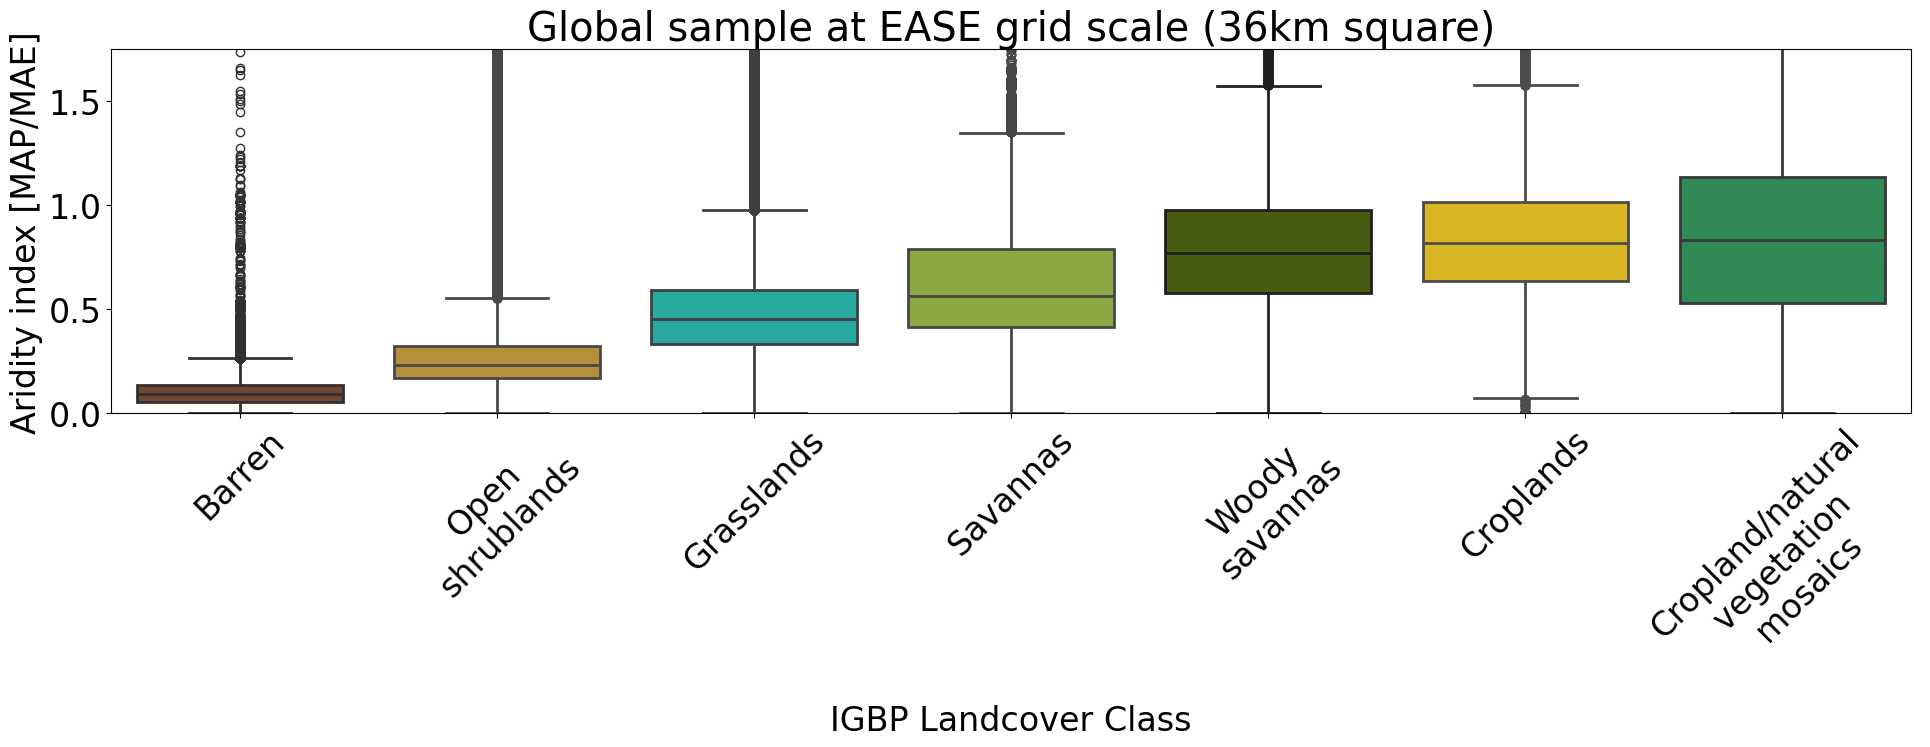

In [31]:
from textwrap import wrap

def wrap_at_space(text, max_width):
    parts = text.split(" ")
    wrapped_parts = [wrap(part, max_width) for part in parts]
    return "\n".join([" ".join(wrapped_part) for wrapped_part in wrapped_parts])

plt.rcParams.update({'font.size': 24})  # Adjust the font size as needed

fig, ax =  plt.subplots(figsize=(20, 8))
for i, category in enumerate(color_dict.keys()):
    subset = df[df['abbreviation'] == category]
    sns.boxplot(x='name', y='AI', data=subset, color=color_dict[category], ax=ax, linewidth=2)

# ax = sns.violinplot(x='abbreviation', y='q_q', data=filtered_df, order=vegetation_orders, palette=palette_dict) # boxprops=dict(facecolor='lightgray'), 
max_label_width = 20
ax.set_xticklabels([wrap_at_space(label.get_text(), max_label_width) for label in ax.get_xticklabels()])
plt.setp(ax.get_xticklabels(), rotation=45)

# ax.set_xticklabels([textwrap.fill(t.get_text(), 10) for t in ax.get_xticklabels()])
ax.set_ylabel("Aridity index [MAP/MAE]")
ax.set_xlabel("IGBP Landcover Class")
ax.set_ylim(0, 1.75)
ax.set_title("Global sample at EASE grid scale (36km square)")
plt.tight_layout()

# IGBP land_cover and aridity index relationship (where SMAP are sampled)

In [10]:
dir_name = f"raraki_2023-11-25_global_95asmax"

In [11]:
input_file = rf"/home/raraki/waves/projects/smap-drydown/output/{dir_name}/all_results.csv"
_df = pd.read_csv(input_file)
coord_info_file = "/home/raraki/waves/projects/smap-drydown/data/datarods/coord_info.csv"
coord_info = pd.read_csv(coord_info_file)
df_data = _df.merge(coord_info, on=['EASE_row_index', 'EASE_column_index'], how='left')
print(len(df_data))
df_data.head()

588194


,Unnamed: 0,EASE_row_index,EASE_column_index,event_start,event_end,time,sm,min_sm,max_sm,pet,...,exp_r_squared,exp_y_opt,q_k,q_q,q_delta_theta,q_r_squared,q_y_opt,id,latitude,longitude
0,0,6,730,2015-07-07,2015-07-11,[1 2 3 4],[0.30713837 0.28085642 0.24799749 0.22460759],0.088373,0.318546,1.442777,...,0.971327,"[0.30721188076022926, 0.2729472772819034, 0.24...",0.097634,7.248424e-14,1.000000,0.949016,"[0.29607309083610084, 0.27360024792220194, 0.2...",6514,74.71601,92.80083
1,1,6,730,2015-09-04,2015-09-09,[1 2 3 4 5],[0.31340383 0.2997787 0.29239778 0.28315416 0...,0.088373,0.318546,0.564329,...,0.934791,"[0.3143936336489097, 0.30014785762607954, 0.28...",0.042653,4.914108e-15,1.000000,0.937212,"[0.3087283792729129, 0.2989108247958259, 0.289...",6514,74.71601,92.80083
2,2,6,730,2018-08-14,2018-08-28,[ 2 3 4 5 6 7 8 9 10 11 12 13 14],[0.31223514 0.29456268 0.2779323 0.2713341 0...,0.088373,0.318546,0.861008,...,0.578249,"[0.29981222834147464, 0.29402804842083086, 0.2...",0.079208,1.063666e+01,1.000000,0.594935,"[0.29743873412168303, 0.2917893984623552, 0.28...",6514,74.71601,92.80083
3,0,6,731,2015-07-07,2015-07-12,[1 2 3 4 5],[0.29125712 0.26151791 0.22887894 0.23347034 0...,0.086197,0.313482,1.390767,...,0.958683,"[0.2919720832552387, 0.25676322377973104, 0.23...",0.157485,2.233977e+00,1.000000,0.913024,"[0.2830171775741852, 0.26038232314236803, 0.24...",6515,74.71601,93.17427
4,1,6,731,2015-09-04,2015-09-10,[2 3 4 5 6],[0.28169658 0.2896581 0.26309461 0.24856516 0...,0.086197,0.313482,0.578359,...,0.648419,"[0.2860845033697074, 0.2752390328406541, 0.266...",0.067436,2.643255e+00,0.995962,0.652026,"[0.2867481281787417, 0.2764784662039014, 0.267...",6515,74.71601,93.17427


In [12]:
df = df.merge(df_data, on=['EASE_row_index', 'EASE_column_index'], how='left')

NameError: name 'wrap' is not defined

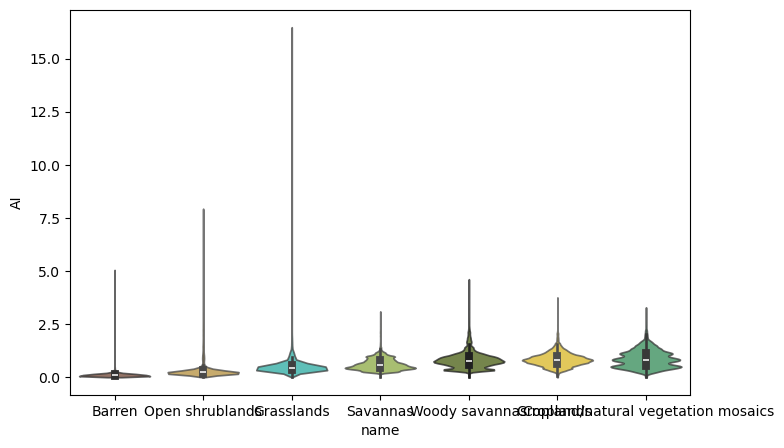

In [13]:
import textwrap
def wrap_at_space(text, max_width):
    parts = text.split(" ")
    wrapped_parts = [wrap(part, max_width) for part in parts]
    return "\n".join([" ".join(wrapped_part) for wrapped_part in wrapped_parts])

fig, ax =  plt.subplots(figsize=(8, 5))
for i, category in enumerate(color_dict.keys()):
    subset = df[df['abbreviation'] == category]
    sns.violinplot(x='name', y='AI', data=subset, color=color_dict[category], ax=ax, alpha=0.75, cut=0)

# ax = sns.violinplot(x='abbreviation', y='q_q', data=filtered_df, order=vegetation_orders, palette=palette_dict) # boxprops=dict(facecolor='lightgray'), 
max_label_width = 20
ax.set_xticklabels([wrap_at_space(label.get_text(), max_label_width) for label in ax.get_xticklabels()])
plt.setp(ax.get_xticklabels(), rotation=45)

# ax.set_xticklabels([textwrap.fill(t.get_text(), 10) for t in ax.get_xticklabels()])
ax.set_ylabel("Aridity index [MAP/MAE]")
ax.set_xlabel("IGBP Landcover Class")
ax.set_ylim(0, 4)
ax.set_title("SMAP drydown event samples")
plt.tight_layout()

In [88]:
filtered_df = df[df.name.isin(selected_categories)]
filtered_df[["id_x","name"]].groupby("name").count()

,id_x
name,
Barren,80979
Cropland/natural vegetation mosaics,42885
Croplands,105645
Grasslands,142373
Open shrublands,85605
Savannas,88235
Woody savannas,74012


In [97]:
# Specify the AI bins
ai_bins = [i * 0.25 for i in range(9)]

# Use pd.cut to create a new column with the bin labels
filtered_df['AI_bins'] = pd.cut(filtered_df['AI'], bins=ai_bins, labels=[f"{i}-{i+0.25}" for i in ai_bins[:-1]])

# Count the number of samples in each bin
bin_counts = filtered_df['AI_bins'].value_counts().sort_index()

print(bin_counts)

AI_bins
0.0-0.25    145427
0.25-0.5    169278
0.5-0.75    128975
0.75-1.0     94972
1.0-1.25     47317
1.25-1.5     17623
1.5-1.75      7422
1.75-2.0      3381
Name: count, dtype: int64


/tmp/ipykernel_1309283/574914312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AI_bins'] = pd.cut(filtered_df['AI'], bins=ai_bins, labels=[f"{i}-{i+0.25}" for i in ai_bins[:-1]])


In [102]:
result = filtered_df[['id_x','abbreviation', 'AI_bins']].groupby(['abbreviation', 'AI_bins']).count()
result

/tmp/ipykernel_1309283/2199596936.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = filtered_df[['id_x','abbreviation', 'AI_bins']].groupby(['abbreviation', 'AI_bins']).count()


id_x
abbreviation AI_bins        
BAR          0.0-0.25  78654
             0.25-0.5   2000
             0.5-0.75     71
             0.75-1.0     79
             1.0-1.25     59
             1.25-1.5      5
             1.5-1.75      7
             1.75-2.0      2
CNM          0.0-0.25   1144
             0.25-0.5   8162
             0.5-0.75   8480
             0.75-1.0   9799
             1.0-1.25   7655
             1.25-1.5   4460
             1.5-1.75   2174
             1.75-2.0    481
CRO          0.0-0.25   1107
             0.25-0.5  12539
             0.5-0.75  28516
             0.75-1.0  35585
             1.0-1.25  17389
             1.25-1.5   7095
             1.5-1.75   2072
             1.75-2.0    776
GRA          0.0-0.25  13644
             0.25-0.5  71078
             0.5-0.75  41494
             0.75-1.0   8419
             1.0-1.25   4542
             1.25-1.5   1278
             1.5-1.75    736
             1.75-2.0    364
OSH          0.0-0.25  47640
             0.25-0.5  28901
             0.5-0.75   2182
             0.75-1.0   1709
             1.0-1.25   1215
             1.25-1.5    831
             1.5-1.75    626
             1.75-2.0    510
SAV          0.0-0.25   3182
             0.25-0.5  32576
             0.5-0.75  27507
             0.75-1.0  16833
             1.0-1.25   6805
             1.25-1.5    833
             1.5-1.75    197
             1.75-2.0    114
WSA          0.0-0.25     56
             0.25-0.5  14022
             0.5-0.75  20725
             0.75-1.0  22548
             1.0-1.25   9652
             1.25-1.5   3121
             1.5-1.75   1610
             1.75-2.0   1134